# Einführung in Elastic Search

### Inhalt

1. Was ist Elastic Search?
2. Docker mit Python
3. Die Elastic API mit Kibana
  * Python API auch hier parallel schon
4. Elastic Search mit Python
5. Aufgaben Szenario

Dieses Notebook wird begleitet von einer live Demo von Elastic Search und Kibana. Es kann daher sein, dass es an manchen Stellen unvollständig ist und nur Notizen für Demos enthält.


In [2]:
!jupyter nbconvert --to html "einführung elastic search.ipynb"

[NbConvertApp] Converting notebook einführung elastic search.ipynb to html
[NbConvertApp] Writing 734184 bytes to einführung elastic search.html


## Einordnung in die Pipeline

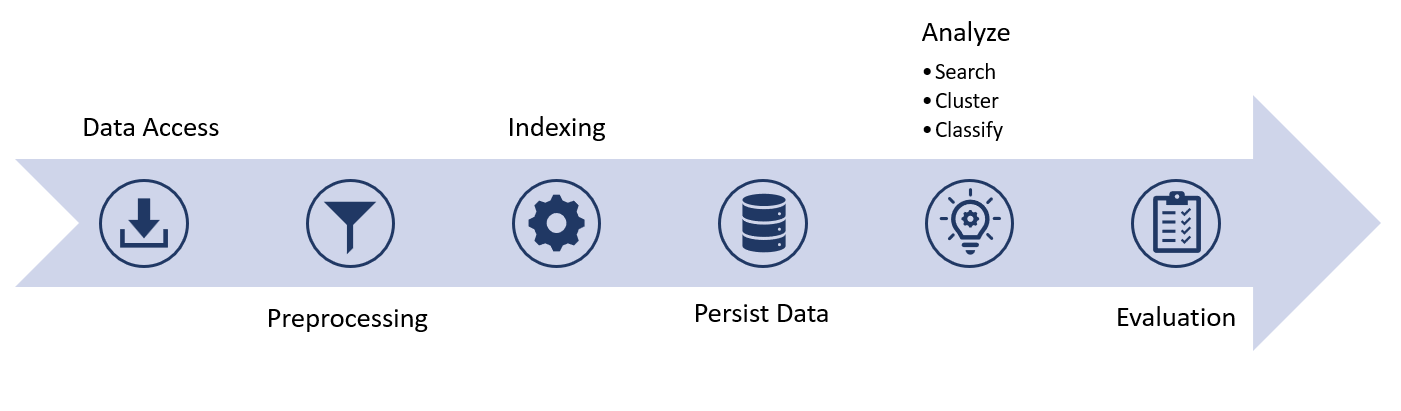

# 1. Was ist Elastic Search?

**Schnelle Fakten:**
* Suchmaschine & Datenbank
  * Suchmaschine basiert auf Apache Lucene: Engine für Volltextsuche
  * Datenbank: speichert im NoSQL-Format
* Schnittstelle: REST-API
  * Die Python-API greift lediglich auf diese zu
  * JSON-Format
* Open Source, in Java programmiert
* Industriestandard
  * u.a. Wikipedia, Microsoft, Netflix, Uber, Tinder...

* Elastic Search gehört zum Elastic Stack, der eine ganze Toolchain umfasst:
  * **Elastic Search** (Datenbank, Suchmaschine)
  * **Kibana** (Analyse, Visualisierung)
  * Logstash (Data Pipeline Setup, Big Data)
  * Beats (Datenintegration)
  * ... und weitere
  
* Wird auch als ELK-Stack (Elastik, Logstash, Kibana) bezeichnet.

* [ELK Homepage](https://www.elastic.co/de/what-is/elk-stack)

## Use cases

* Schritt 4 (Datenpersistenz)
* Schritt 3 (Indexing)
* Schritt 2 (Preprocessing)
* Schritt 5 (Analysis)
  * Abfragen: wildcards, search ranges, etc.
  * gewichtete Suche
  * Vector Space modelling
  * Nearest Neighbour Search (auch als Clustering)
  * Tools für Visualisierung & deskriptive Statistik
  * und vieles mehr...

Klären von Begriffen:
* REST-API
* NoSQL-Datenbank
  * Keine Tabular-Beziehungen im Datenschema _nötig_.
  * Zeilen eines Datensatzes können Spalten haben, die andere des selben nicht haben.
    * einfache Erweiterbarkeit
  * SQL Datenstrukturen sind damit aber genauso abbildbar, jedoch nicht umgekehrt.
  * Beispiele:
    * Key-Value-Store (Hash-Table)
    * Elastic Search (Document Store)

#### Elastic Search vs SQL Datenbank:

| **Elastic**    | **SQL**         |
|----------------|-----------------|
|     Index      |     Database    |
|     Mapping    |     Table       |
|     Type       |     Column      |

# 2. Docker mit Python nutzen

* Sie können Docker auch aus Python direkt ansprechen. Das kann Arbeit ersparen, da Sie nicht jedes Mal alle Befehle (vor allem die Parameter) erneut tippen bzw. auch nicht auswendig können müssen. 
* Die Nutzung von Python ist jedoch nur eine Alternative, wer möchte kann alles per Kommandozeile machen.

* Zunächst muss der Docker Host laufen. Diesen starten Sie am besten über Docker Desktop.
* Importieren Sie das Modul ``docker``.
  * Installierbar mit pip oder conda
* Stellen Sie eine Verbindung mit Docker her durch ``docker.from_env()``.

In [1]:
import docker

client = docker.from_env()

## Einen Container starten (Elastic Search)

* Starten Sie einen neuen Container mit: ``client.containers.run(image=<image>, ports=<PORT_MAPPING>, name=<NAME>, environment=<ENV>, network=<NETWORK>)``.

In [7]:
# Freigabe der Ports
PORTS = {"9200": 9200, "9300": 9300}
ENV = {"discovery.type": "single-node", "xpack.security.enabled": "false"}
container = client.containers.run(image="docker.elastic.co/elasticsearch/elasticsearch:8.0.1", ports=PORTS, name="elasticsearch-8", detach=True, environment=ENV,
                      network="elastic")

#### Läuft der Container?

Folgender Befehl gibt Ihnen alle laufenden Container aus:

In [7]:
print("Running containers:")
for container in client.containers.list():
    print(container.name)

Running containers:
kibana-8
elasticsearch-8


Mit dem Parameter ``all=True`` sehen Sie alle existierenden Container (auch die aktuell gestoppten).

In [4]:
print("All containers:")
for container in client.containers.list(all=True):
    print(container.name)

All containers:
kibana-8
elasticsearch-8
kibana
elasticsearch
elastic_from_python
fuseki
clever_nash
ckan
solr
redis
db
datapusher


In [6]:
client.containers.get("elasticsearch-8").start()
client.containers.get("kibana-8").start()

Dies können Sie auch in Docker Desktop unter Container oder auf der Kommandozeile mit ``docker container list`` sehen.

In [ ]:
# Freigabe der Ports
PORTS = {"9200": 9200, "9300": 9300}
VOLUME = {"elastic-stuff-8": {"bind": "/usr/share/elasticsearch/data", "mode": "rw"}}
ENV = {"discovery.type": "single-node", "xpack.security.enabled": "false"}
# client.containers.run(image="elasticsearch:7.16.3", ports=PORTS, name="elasticsearch", detach=True, environment=ENV, volumes=VOLUME, network="elastic")
client.containers.run(image="docker.elastic.co/elasticsearch/elasticsearch:8.0.1", ports=PORTS, name="elasticsearch-8", detach=True, environment=ENV,
                      volumes=VOLUME,
                      network="elastic")

Container können auch gestoppt und gelöscht werden:

In [13]:
container = client.containers.get("elasticsearch-8")

# stoppen
container.stop()
# wieder starten
container.start()

# container löschen, auskommentiert um ungewolltes Löschen zu vermeiden
# container.remove()

### Kibana im Container starten

Dies startet Kibana in einem Docker Container. Kibana ist dann unter localhost:5601 erreichbar sein. Sollte bei Ihnen im Browser eine Fehlermeldung kommen, deaktivieren Sie Ihren Adblocker.

Äußerst wichtig ist:
* dass Elastic Search und Kibana im selben Docker Network sind.
* dass Kibana die Adresse von Elastic Search mitgeteilt wird (``ELASTIC_HOST``).

In [19]:
PORTS = {"5601": 5601}
ENV = {"ELASTICSEARCH_HOSTS": "http://elasticsearch-8:9200"}
container = client.containers.run(image="docker.elastic.co/kibana/kibana:8.0.1", ports=PORTS, name="kibana-8", detach=True, network="elastic", environment=ENV)

Falls Sie nicht mit der Python-Docker-API arbeiten möchten (oder sie nicht läuft) können Sie natürlich auch die Kommandozeile nutzen. Ich liste Ihnen daher hier die Befehle für das Starten der beiden Container auf. Werte in <>-Klammern bitte durch Ihre ersetzen.

* Elastic Search: ```docker run --name <name> -d --net elastic -p 9200:9200 -p 9300:9300 -e "discovery.type=single-node" -e "xpack.security.enabled=false" docker.elastic.co/elasticsearch/elasticsearch:8.0.1```
* Kibana: ```docker run --name <name> -d -p 5601:5601 --net elastic docker.elastic.co/kibana/kibana:8.0.1```

### Kibana mit Elastic Search verknüpfen

**Dieser Abschnitt ist nur relevant, wenn nach dem Starten des Kibana Containers auf localhost:5601 ein Fenster mit der Meldung "Configure Elastic to get startet" erscheint.**

* Seit der Version 8 wurde Elastic um mehrere Sicherheitsfeatures erweitert, daher müssen wir nun einige zusätzliche Schritte durchführen.
* Geben Sie unter "configure manually" ein: ``http://<name-elastic-container>:9200``. Ihr Elastic Search Container sollte natürlich laufen und unter Port 9200 erreichbar sein.
* Klicken Sie auf "configure elastic" und ein Fenster für die Eingabe mit einem Sicherheitscode erscheint.
  * Den Code finden Sie im Log des Kibana-Container: Dazu Doppelklicken auf den Container in Docker Desktop.
* Anschließend sollte die Sicherheitsprüfung abgeschlossen sein und Sie können mit Kibana durchstarten.

# 3. Die Elastic Search API mit Kibana

* Die Kommunikation mit Elastic Search findet über die REST-API statt
  * Die offizielle Dokumentation (8.0) ist [hier](https://www.elastic.co/guide/en/elasticsearch/reference/8.0/index.html) zu finden.
* Python wird später lediglich diese REST-API "ummanteln", daher wollen wir zunächst die REST-API als solche verstehen.

* Kibana bietet hervorragende Tools für das Lernen der Elastic Search API unter anderem mit
  * Syntax highlighting
  * auto completion
  * error checking
* Zu finden sind diese:
  * Main Menu/Dev Tools/Console

### Daten hinzufügen

* Wird dies in der Kibana Konsole ausgeführt, wird ein neues Dokument in Elastic Search gespeichert.
* Klicken Sie dazu auf den grünen Pfeil am rechten Rand der Anfrage.

```
POST band-data/_doc
{
  "band": "Linkin Park",
  "song": "In The End",
  "album": "Hybrid Theory"
}
```

* ``POST`` wird überlicherweise verwendet, um Daten an einen Server zu schicken
* Die Daten werden unter dem Index ``band-data`` gepeichert (dazu später mehr)
* \_doc steht für _Dokument_.
* Das Dokument enthält 3 Types im JSON-Format:
  * band, song und album


### Daten hinzufügen (mit Python)

* Um es Ihnen leichter zu machen, wenden wir das selbe direkt in Python an.
* Die offizielle Python Elastic Search API finden Sie [hier](https://elasticsearch-py.readthedocs.io/en/v8.1.2/).

In [2]:
# import of elastic search python module, install with pip or anaconda
from elasticsearch import Elasticsearch

# connect to elastic search
es = Elasticsearch("http://localhost:9200")
# check if connection was established successfully
es.ping()

True

In [3]:
# wir erstellen unser Dokument, genau wie auch zuvor in Kibana
doc = {
    'song': 'In The End',
    'album': 'Hybrid Theory',
    'band': "Linkin Park",
}

# mit der index Methode werden Daten in Elastic gespeichert.
# Dabei wird der Index band-data-python erstellt, wenn noch nicht vorhanden
# dem Parameter document übergeben wir unser Dokument
res = es.index(index="band-data-python", document=doc)
print(res['result'])

created


## Daten auslesen & suchen

**Auslesen des gesamten Indexes:**
```
GET band-data/_search
{
  "query": {
    "match_all": { }
  }
}
```

* Da vom Server Daten abgefragt werden, muss hier ``GET`` genutzt werden.
* wichtig ist hier, dass der Name des zuvor gewählten Index ``band-data`` gleich ist.
* mit ``query`` leiten wir die Suche ein. Da nichts weiter angegeben wurde, wird der gesamte Index abgefragt. Die Abfrage kann natürlich weitaus komplexer sein, auch dazu später mehr.

Ergebnis:
```
{
  "took" : 2,
  "timed_out" : false,
  "_shards" : {
    "total" : 1,
    "successful" : 1,
    "skipped" : 0,
    "failed" : 0
  },
  "hits" : {
    "total" : {
      "value" : 3,
      "relation" : "eq"
    },
    "max_score" : 1.0,
    "hits" : [
      {
        "_index" : "band-data",
        "_id" : "hYRKA4ABmRhRDkTnOMc8",
        "_score" : 1.0,
        "_source" : {
          "band" : "Linkin Park",
          "song" : "In The End",
          "album" : "Hybrid Theory"
        }
      }
    ]
  }
}

```

#### Auslesen des gesamten Index (mit Python)

* Methode: ``es.search``
* Sie sehen, der Wert des query-Parameters ist der gleiche wie auch schon in Kibana!
* auch das Ergebnis der Abfrage wird von der Python API 1:1 von Elastic durchgereicht.

In [4]:
es.search(index="band-data-python", query={"match_all": {}})

ObjectApiResponse({'took': 11, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 1.0, 'hits': [{'_index': 'band-data-python', '_id': 'REwLpYABI1XhAUHMMetp', '_score': 1.0, '_source': {'song': 'In The End', 'album': 'Hybrid Theory', 'band': 'Linkin Park'}}]}})

**Textsuche innerhalb eines Feldes:**
* An der URI der Anfrage ändert sicht zur Vorherigen Abfrage nichts.
* Lediglich die Parameter der Abfrage werden verändert.

```
GET band-data/_search
{
  "query": {
    "simple_query_string": {
      "fields": [
        "song"
      ],
      "query": "end"
    }
  }
}
```

* durch ``simple_query_string`` wird angegeben, dass eine einfache Textsuche gewünscht ist.
* es muss angegeben werden, welche Felder dafür in Frage kommen (``fields``)
* die ``query`` gibt an, nach was wir suchen wollen

Ergebnis:
```
{
  "took" : 5,
  ...
  },
  "hits" : {
    "total" : {
      "value" : 1,
      "relation" : "eq"
    },
    "max_score" : 0.9331132,
    "hits" : [
      {
        "_index" : "band-data",
        "_id" : "hYRKA4ABmRhRDkTnOMc8",
        "_score" : 0.9331132,
        "_source" : {
          "band" : "Linkin Park",
          "song" : "In The End",
          "album" : "Hybrid Theory"
        }
      }
    ]
  }
}

```


**Textsuche innerhalb eines Feldes mit Python):**

* Auch dies ist 1:1 wie im Beispiel in Kibana.

In [5]:
query= {"simple_query_string": {
        "fields": [
          "song"
          ],
        "query": "end"
       }
    }
es.search(index="band-data-python", query=query)

ObjectApiResponse({'took': 54, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 1, 'relation': 'eq'}, 'max_score': 0.2876821, 'hits': [{'_index': 'band-data-python', '_id': 'REwLpYABI1XhAUHMMetp', '_score': 0.2876821, '_source': {'song': 'In The End', 'album': 'Hybrid Theory', 'band': 'Linkin Park'}}]}})

### Visualisieren mit Kibana

* Kibana bietet Ihnen einige schicke Möglichkeiten Ihre Daten aus Elastic Search zu visualieren.
* Zunächst muss dafür jedoch noch ein _Data View_ erstellt werden
  * Dies ist nötig um ggf. mehrere Indices zu inkludieren
  * Dies geht unter Main Menu/Stack Management/Data Views/Create Data View
  * Wir erstellen den Data View _band-data_. An dieser Stelle kann auch mit Wildcards (*) gearbeitet werden.
  * Ein Blick lohnt nun auch auf die Übersicht des erstellten Data Views.

* Für die Analyse gehen wir auf Main Menu/Analysis/Discover.
* Auf der linken Seite können erstellte Data Views ausgewählt werden. Wir wählen ``band-data``.
* Unter _Available Fields_ sehen wir alle erstellten Datenfelder.
* Wir wollen uns das Feld _bands_ genauer anschauen. Dazu klicken wir auf das Feld und dann _Visualize_. Der Graph Editor (Lense) öffnet.
* Kibana zeichnet uns ein Säulendiagramm nach Anzahl für Jede Band. Wir wechseln unten zur Donat Visualisierung.
* Weitere Felder können durch Drag & Drop direkt aggregiert werden, z.B. Bands nach Album.




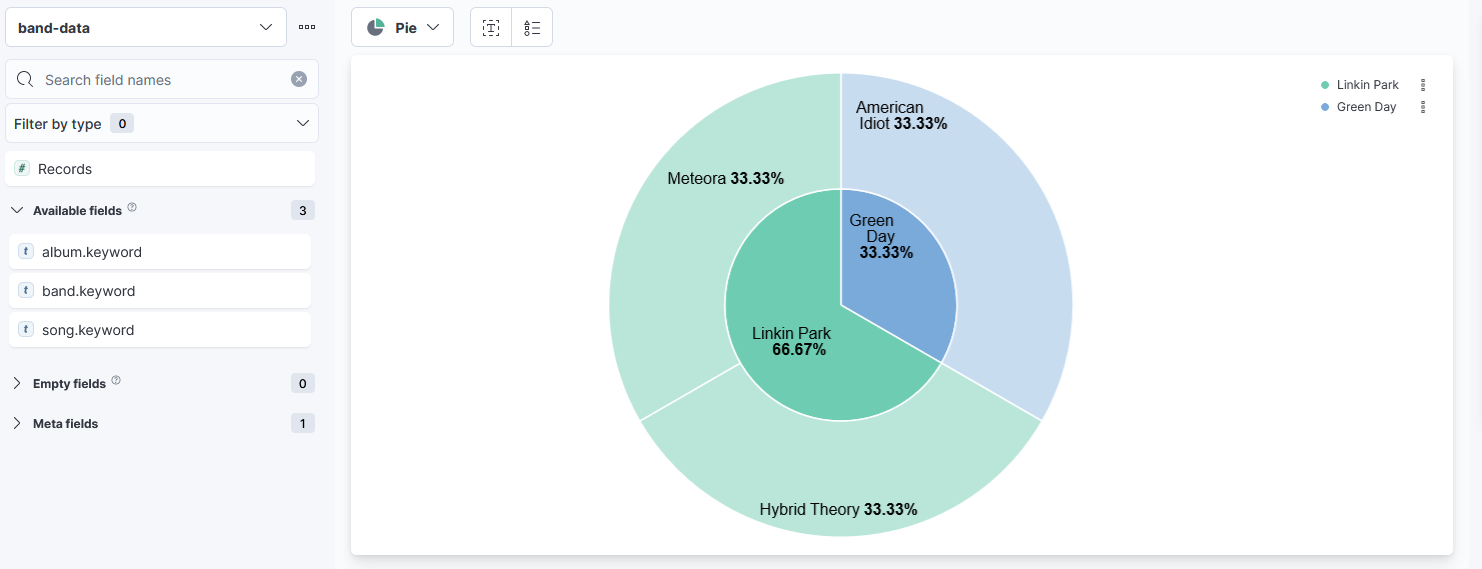

# 4. Elastic Search mit Python

* Unser Use Case bezieht sich auf das Laden eines gesamten Textkorpus in Elastic Search.
* Jedes Dokument einzeln zu laden wäre mühsam.
* Daher wird dies mit Python automatisiert.

* Für das Laden großer Datenmengen stellt Elastic Search den ``bulk``-Endpoint bereit.
  * Dokumentationen: [Elastic Search](https://www.elastic.co/guide/en/elasticsearch/reference/current/docs-bulk.html), [Python](https://elasticsearch-py.readthedocs.io/en/v8.1.2/api.html?highlight=bulk#elasticsearch.Elasticsearch.bulk)
* Diese Schnittstelle nimmt ein einzelnes Dictionary (JSON) entgegen.
* Mit nur einer einzigen Request können so mehrere Daten auf einmal geladen werden.

In [6]:
# Bauen des Dictionaries
docs = ["deutschland", "frankreich"]

request = []
for doc in docs:
    data = {
    "_index": "country-index",
    "_source": {
        # doc_text ist der Name des Felds ('Spalte') und kann beliebig gewählt werden.
        "doc_text":doc
        }
    }
    request.extend([data])

In [7]:
request

[{'_index': 'country-index', '_source': {'doc_text': 'deutschland'}},
 {'_index': 'country-index', '_source': {'doc_text': 'frankreich'}}]

In [8]:
from elasticsearch.helpers import bulk

bulk(es, request)

(2, [])

# 5. Aufgaben Szenario

Diese Aufgaben bilden ein Szenario ab, bei dem Sie den Country-Corpus automatisiert nach Elastic Search laden sollen. Anschließend sollen Sie eine kleine Visualisierung der Daten mit Kibana vornehmen.

Die Aufgaben sind bewusst ein wenig freier gestellt und sollen Sie in Richtung der Prüfungsabgabe vorbereiten.

**Teil A** (Schritte 1 - 4)

1. **Data Acess & Preprocessing**: Passen Sie Ihren Tokenizer an und laden Sie den Country-Corpus:
  * Unterteilen Sie zudem die Dokumente nach den einzelnen Kapiteln der Wikipedia Artikel. Speichern Sie die einzelnen Tokens zum jeweiligen Kapitel nach dem Laden ab.
2. **Persistenz**: Implementieren Sie eine Funktion, die die Dokumente nach dem Tokenizing entgegennimmt und nach Elastic Search lädt.
  * nutzen Sie die vorgestellte Funktion ``bulk``. Lesen Sie dazu auch in der Dokumentation von Elastic Search und Python Elastic Search!
  * Überlegen Sie sich ein Schema, wie Sie die Daten speichern wollen, sodass später auf die einzelnen Kapitel je Dokument zugegriffen werden kann. Hier gibt es viele Möglichkeiten. Dokumentieren Sie Ihre Argumentation (so etwas erwarte ich auch in der Dokumentation für die Prüfungsarbeit). Es ist dabei auch hilfreich sich das ganze zunächst konzeptionell zu überlegen und aufzumalen.


In [ ]:
import nltk
from nltk.corpus import stopwords
import re

def tokenize_new(document):
    stops = set(stopwords.words('german'))
    document=document.lower()
    r=re.findall(r"\w+", document)
    wordsFiltered = []
    stopw = []
    for w in r:
        if w in stops:
            stopw.append(w)
        else:
            wordsFiltered.append(w)
    wordsFiltered.extend(list(set(stopw)))
    return wordsFiltered

In [ ]:
import os
path = "\Studium\IR\countries\countries"
token_dict = {}
for file in os.listdir(path):
    f=os.path.join(path,file)
    if os.path.isfile(f):
        t= open(f, encoding = "utf-8")
        data=t.read()
        dict = {
            file[:-4]:tokenize_new(data)
        }
    token_dict.update(dict)

**Teil B** (Schritt 5 & 6)

3. **Analyse & Evaluation:**: Vergleichen Sie die Textsuche mit der aus den Aufgaben zuvor aus dem Kapitel _Boolean Retrieval_. Suchen Sie also mit einer geeigneten Elastic Search Query die Dokumente die:
  * meer, gebirge, berge und fluss enthalten.
  * ural und buddhismus enthalten
  * welche Möglichkeiten bietet Elastic Search dabei, die Sie zuvor nicht implementiert hatten?
4. **Analyse (Deskriptiv):** Untersuchen Sie die Kapitelnamen in Kibana. Visualisieren Sie dazu die Häufigkeiten der Kapitel in einem geeigneten Diagramm. Das Diagramm soll z.B. beantworten können:
  * welche Kapitel kommen am häufigsten vor?
  * wie häufig kommt ein bestimmtes Kapitel vor?
5. **Analyse (Deskriptiv):** Erstellen Sie analog wie im Beispiel zuvor ein Donut-Diagramm in Kibana. Für ein Dokument (analog _Bands_ ) sollen die Kapitel nach Länge (Anzahl Tokens, analog _Alben_ ) visualisiert sein.
  * Wie müssen Sie die Daten aggregieren?